Импорт библиотек

In [1346]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Анализ данных

In [1347]:
dt = pd.read_html('/content/Выгрузка 9 апреля.xls')

In [1348]:
df = dt[1]
df.head()

,№ п/п,№документа,Датарегистрации,Исх. №Дата,Адресат,Автор,Краткоесодержание,Примечание
0,1,WSR/1-838/2019,09.04.2019,208-40908.04.2019,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...,NaN
1,2,WSR/1-837/2019,09.04.2019,05-33809.04.2019,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...,NaN
2,3,WSR/1-835/2019,09.04.2019,И10-14/313709.04.2019,Уразов Р.Н.,Цивилев С.Е. (Администрация Кемеровской области),Вх - О командировании Саликовой К. и Глушко Д....,NaN
3,4,WSR/1-834/2019,09.04.2019,Д2/7121-ИС03.04.2019,Иванюк Л.А.,Волков Г.А. (Министерство транспорта Российско...,Вх - Об участии в Чемпионате мира по профессио...,NaN
4,5,WSR/1-833/2019,09.04.2019,15-20/06-91108.04.2019,Уразов Р.Н.,Атанов И.В. (Ставропольский государственный аг...,Вх - Об участии в церемонии открытия Вузовског...,NaN


Информация

In [1349]:
df.describe()

,№ п/п
count,4967.000000
mean,2484.000000
std,1433.993724
min,1.000000
25%,1242.500000
50%,2484.000000
75%,3725.500000
max,4967.000000


In [1350]:
df.shape

(4967, 8)

In [1351]:
df.info

<bound method DataFrame.info of       № п/п  ... Примечание
0         1  ...        NaN
1         2  ...        NaN
2         3  ...        NaN
3         4  ...        NaN
4         5  ...        NaN
...     ...  ...        ...
4962   4963  ...        NaN
4963   4964  ...        NaN
4964   4965  ...        NaN
4965   4966  ...        NaN
4966   4967  ...        NaN

[4967 rows x 8 columns]>

Предобработка данных и выделение значимых атрибутов

In [1352]:
dt[0].T[0]
dt[0].T[1].unique().tolist()
dt[0].T[2].unique().tolist()
df = dt[1]

In [1353]:
df = dt[1].drop(['№ п/п', '№документа', 'Исх. №Дата', 'Примечание'], axis=1)
df.head(2)

,Датарегистрации,Адресат,Автор,Краткоесодержание
0,09.04.2019,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...
1,09.04.2019,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...


Регулярные выражение

In [1354]:
import re

In [1355]:
adres = []
c = 0
reg_fio = r'([А-Я]\.[А-Я]\.\s?[А-Я][а-я]{1,20}|[А-Я][а-я]{1,20}\s?[А-Я]\.[А-Я]\.)'
for i in df.Адресат:
  result = re.findall(reg_fio, i)[-1]
  adres.append(result.replace(' ',''))

df['Адресат(-ы)'] = adres
df.tail(2)

,Датарегистрации,Адресат,Автор,Краткоесодержание,Адресат(-ы)
4965,01.11.2017,Уразов Р.Н.,Огородова Л.М. (Министерство образования и нау...,Протокол заседания рабочей группы приоритетног...,УразовР.Н.
4966,NaN,Уразов Р.Н.,Асаул Н.А. (Министерство транспорта Российской...,Участие в Чемпионате WorldSkills Hi-Tech Екате...,УразовР.Н.


Дополнение недостающими данными

In [1356]:
df['Адресат(-ы)'].unique().shape

(81,)

In [1357]:
df.Датарегистрации = pd.to_datetime(df.Датарегистрации)
df.Датарегистрации.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                    4965
unique                    372
top       2017-11-29 00:00:00
freq                       42
first     2017-01-11 00:00:00
last      2019-12-03 00:00:00
Name: Датарегистрации, dtype: object

In [1358]:
df['Агентсво'] = df.Автор.apply(lambda x: x.split('(')[1].replace(')',''))

In [1359]:
df.head(2)

,Датарегистрации,Адресат,Автор,Краткоесодержание,Адресат(-ы),Агентсво
0,2019-09-04,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...,УразовР.Н.,АО «Интерфакс»
1,2019-09-04,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...,УразовР.Н.,Министерство просвещения Российской Федерации


Переписать список откуда и куда, сравнивать строки

In [1360]:
agents = []
target = ['Министерств','Правительств','Федеральн','Администр']
for i in df.Агентсво:
  br = 0
  for t in target:
    if br:
      break
    if t in i:
      br = 1
      agents.append(1)
  if not(br):
    agents.append(0)

In [1361]:
df['Тип_агентсва'] = agents
df.head()

,Датарегистрации,Адресат,Автор,Краткоесодержание,Адресат(-ы),Агентсво,Тип_агентсва
0,2019-09-04,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...,УразовР.Н.,АО «Интерфакс»,0
1,2019-09-04,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...,УразовР.Н.,Министерство просвещения Российской Федерации,1
2,2019-09-04,Уразов Р.Н.,Цивилев С.Е. (Администрация Кемеровской области),Вх - О командировании Саликовой К. и Глушко Д....,УразовР.Н.,Администрация Кемеровской области,1
3,2019-09-04,Иванюк Л.А.,Волков Г.А. (Министерство транспорта Российско...,Вх - Об участии в Чемпионате мира по профессио...,ИванюкЛ.А.,Министерство транспорта Российской Федерации,1
4,2019-09-04,Уразов Р.Н.,Атанов И.В. (Ставропольский государственный аг...,Вх - Об участии в церемонии открытия Вузовског...,УразовР.Н.,Ставропольский государственный аграрный универ...,0


In [1362]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
def stm(doc):
    tokens = []
    for token in doc.split():
      token = stemmer.stem(token)
      tokens.append(token)
    if len(tokens) > 0:
        return (" ").join(tokens)
    return None

In [1363]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Векторизация

In [1364]:
X = df.Адресат
y = df.Тип_агентсва

In [1365]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [1366]:
vectorizer = TfidfVectorizer(max_features = 10000)

In [1367]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [1368]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

In [1369]:
%%time
model_SVC = SVC(C = 1, kernel = 'linear')
model_SVC.fit(X_train, y_train)
res = model_SVC.predict(X_test)

CPU times: user 322 ms, sys: 19.4 ms, total: 341 ms
Wall time: 347 ms


In [1370]:
f1_svm = f1_score(y_test, res, average='macro')
f1_svm

0.6120975609756099

Алгоритм выдал ~60

In [1371]:
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71       596
           1       0.56      0.47      0.51       398

    accuracy                           0.64       994
   macro avg       0.62      0.61      0.61       994
weighted avg       0.63      0.64      0.63       994



#Catboost

In [1372]:
!pip install catboost

In [1373]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

In [1374]:
cat.fit(X_train,y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Кроссвалидацию

In [1375]:
from catboost import Pool, cv
params = {"iterations": 100,
          "depth": 10,
          "loss_function": "RMSE",
          "verbose": False}
cv_dataset = Pool(data=X_train,
                  label=y_train)
scores = cv(cv_dataset,
            params,
            fold_count=10, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.469638386
bestIteration = 99

Training on fold [1/10]

bestTest = 0.4639506812
bestIteration = 99

Training on fold [2/10]

bestTest = 0.4676880137
bestIteration = 99

Training on fold [3/10]

bestTest = 0.4695339344
bestIteration = 99

Training on fold [4/10]

bestTest = 0.4641099513
bestIteration = 99

Training on fold [5/10]

bestTest = 0.4557904244
bestIteration = 99

Training on fold [6/10]

bestTest = 0.483231348
bestIteration = 99

Training on fold [7/10]

bestTest = 0.4715613458
bestIteration = 99

Training on fold [8/10]

bestTest = 0.4650938038
bestIteration = 99

Training on fold [9/10]

bestTest = 0.4651710135
bestIteration = 99



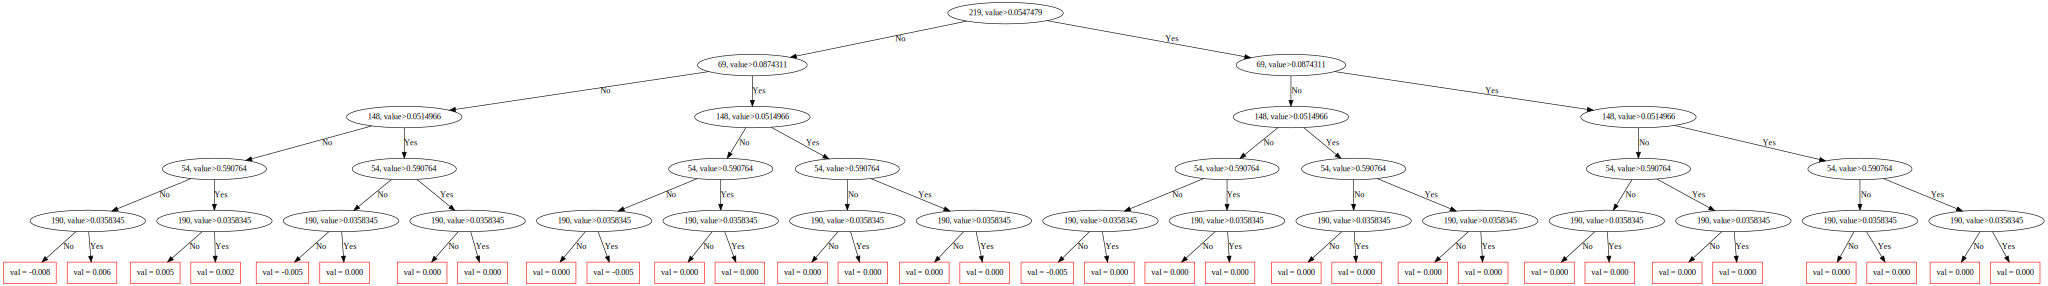

In [1376]:
cat.plot_tree(tree_idx=0)

#Xgboost

In [1377]:
!pip install xgboost

In [1378]:
import numpy
import xgboost
from sklearn.metrics import accuracy_score

In [1379]:
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier()

Делаю прогнозы для тестовых данных

In [1380]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Точность: %.2f%%" % (accuracy * 100.0))

Точность: 63.68%


#Random Forest

In [1381]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

from sklearn import metrics
print("Точность:", metrics.accuracy_score(y_test, y_pred))

Точность: 0.6348088531187123



> Лучшие алгоритмы Random Forest, Xgboost (Внатуре :D)

> Векторизация, CatBoost - Показали меньшие показатели